In [1]:
# to know the current path 
!pwd

/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main_change


In [2]:
# to know the current python version
!python --version

Python 3.10.9


In [3]:
# set the cuda visible device at GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [4]:
# necessary liberaries

from os import path as osp
import os
import logging
from PIL import Image
from torch.serialization import save
from args import get_args
from trainer import Trainer
from crisismmd_dataset import CrisisMMDataset#, CrisisMMDatasetWithSSE
from mm_models import DenseNetBertMMModel, ImageOnlyModel, TextOnlyModel
import os
import numpy as np
import torch
from torch.nn.modules import activation
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import time

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gupta.37/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# import torch related liberaries

import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [6]:
# load model weight file

model_to_load = './output/experiments/full_task3/best.pt'
# model_to_load = './output/full_task2_merged/best.pt'
#image_model_to_load = './output/image_only_task1/best.pt'
#text_model_to_load = './output/text_only_task1/best.pt'

In [7]:
device = 'cuda'
num_workers = 1

In [8]:
EVAL = True
USE_TENSORBOARD = False
SAVE_DIR = './output'
model_name = "task3"
MODEL_NAME = model_name if model_name else str(int(time.time()))


In [9]:
MODE = 'both'
TASK = 'task3'
MAX_ITER = 10
OUTPUT_SIZE = None 
if TASK == 'task1':
    OUTPUT_SIZE = 2
elif TASK == 'task2':
    OUTPUT_SIZE = 8
elif TASK == 'task2_merged':
    OUTPUT_SIZE = 6
elif TASK == 'task3':
    OUTPUT_SIZE = 3   
else:
    raise NotImplemented

In [10]:
WITH_SSE = False
pv = 1000 # How many times more likely do we transit to the same class
pt = 1000 
pv0 = 0.3  # Probability of not doing a transition
pt0 = 0.7

In [11]:
learning_rate = 2e-3
batch_size = 1

In [12]:
# Create folder for saving
save_dir = osp.join(SAVE_DIR, MODEL_NAME)
if not osp.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)
if not osp.exists(save_dir):
    os.mkdir(save_dir)

In [13]:
logging.basicConfig(filename=osp.join(save_dir, 'output_{}.log'.format(int(time.time()))), level=logging.INFO)

In [14]:
#code from view.py
class Args:
    pass
opt = Args()
opt.load_size = 228
opt.crop_size = 224
opt.max_dataset_size = 2147483648
opt.debug = False

In [15]:
train_loader, dev_loader = None, None

In [16]:
train_set = CrisisMMDataset()
train_set.initialize(opt, phase='train', cat='all',task=TASK)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

[*] 2468 samples loaded.


In [ ]:
# for i in train_loader:
#     print(i)

In [17]:
test_set = CrisisMMDataset()
test_set.initialize(opt, phase='test', cat='all', task=TASK)

[*] 529 samples loaded.


In [18]:
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [19]:
loss_fn = nn.CrossEntropyLoss()
if MODE == 'text_only':
    model = TextOnlyModel(num_class=OUTPUT_SIZE, save_dir=save_dir).to(device)
elif MODE == 'image_only':
    model = ImageOnlyModel(num_class=OUTPUT_SIZE, save_dir=save_dir).to(device)
elif MODE == 'both':
    model = DenseNetBertMMModel(num_class=OUTPUT_SIZE, save_dir=save_dir).to(device)
else:
    raise NotImplemented

Using cache found in /home/gupta.37/.cache/torch/hub/pytorch_vision_v0.8.0
/home/gupta.37/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gupta.37/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discrimi

In [20]:
#model = nn.DataParallel(model)
# The authors did not mention configurations of SGD. We assume they did not use momentum or weight decay.
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# The authors used factor=0.1, but did not mention other configs.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, cooldown=0, verbose=True)

In [22]:
trainer = Trainer(train_loader, dev_loader, test_loader, model, loss_fn, optimizer, scheduler, eval=EVAL, device=device, tensorboard=USE_TENSORBOARD, mode=MODE)

In [23]:
if model_to_load:
    model.load(model_to_load)
    print("yes")
    logging.info("\n***********************")
    logging.info("Model Loaded!")
    logging.info("***********************\n")
# if text_model_to_load:
#     print("yes")
#     model.module.load(text_model_to_load)
# if image_model_to_load:
#     print("yes")
#     model.module.load(image_model_to_load)

yes


In [24]:
model.eval()

DenseNetBertMMModel(
  (imageEncoder): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e

In [25]:
heatmap_layer = model.imageEncoder.features.denseblock4.denselayer32.conv2

#heatmap_layer = model.module.proj_visual

In [26]:
import cv2
import torch
import numpy as np

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    #plt.imshow(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    #print(tensor.cpu().numpy().shape) 
    image_binary = np.transpose(tensor.cpu().numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, input_tensor, heatmap_layer, img_path, truelabel=None):
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    #print(input_tensor)
    #output = model(input_tensor.unsqueeze(0))[0]
    output = model(input_tensor)
    
    truelabel = torch.argmax(output, dim=1).to(device)
    #print("truelabel is", output[truelabel])
    output[0][truelabel].mean().backward()

    weights = torch.mean(info.gradient, [0, 2, 3])
    
    #print("shape of info gradient", info.gradient.shape)
    #weights = torch.mean(info.gradient, dim=1)
    
    activation = info.activation.squeeze(0)

    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    #print(heatmap)
    
#     transform = transforms.Compose([
#         transforms.Resize(240),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
    
#     image = Image.open(img_path)
#     input_tensor = transform(image)
    
    input_image = to_RGB(input_tensor[0][0])
    
    #plt.imshow(input_image)
    
    #print(input_image)
    #print(size(input_image))

    return superimpose(input_image, heatmap)



/tmp/ipykernel_3583322/2371582665.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_label = torch.tensor(indices).item()
/tmp/ipykernel_3583322/2371582665.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_label = torch.tensor(y).item()


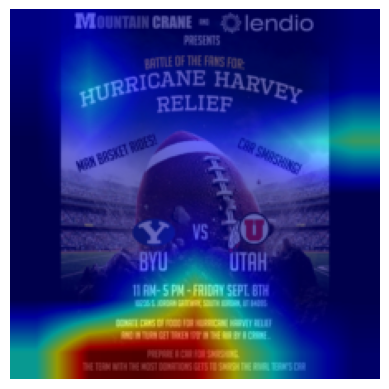

In [52]:
for data in test_loader:
    #print(data)
    #print(data['image'])
    
    x = (data['image'].to(device),
         {k: v.to(device) for k, v in data['text_tokens'].items()})
    img_path = data['path_image'][0]
    #print(img_path)
    y = data['label'].to(device)
    #print("y in the prediction function",y)
    #input_tensor = data['image'].to(device)
    #image = grad_cam(model, x, heatmap_layer,y)
    #plt.savefig('./images/input_grad-cam_v1')
    #logits = model(x)
    with torch.no_grad():
        logits = model(x)
    # indices is a tensor of predictions
    org_img = data['image'].to(device)
    indices = torch.argmax(logits, dim=1).to(dtype=torch.int32)
    
    #print(indices)
    
    pred_label = torch.tensor(indices).item()
    ground_label = torch.tensor(y).item()
    
    image = grad_cam(model, x, heatmap_layer,img_path)
    plt.imshow(image)
    
    filename = data['path_image'][0].split('/')[-1].split('.')[0]
    if pred_label == ground_label :
        #print("yes") 
        plt.axis('off')
        plt.savefig(f'./images/correct_prediction/{filename}_{pred_label}_{ground_label}.jpg')    
    else :
        plt.axis('off')
        plt.savefig(f'./images/incorrect_prediction/{filename}_{pred_label}_{ground_label}.jpg') 
        
    break

In [27]:
import torchvision.transforms as transforms
from base_dataset import expand2square
from preprocess import clean_text
from transformers import BertTokenizer, ElectraTokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')#BertTokenizer.from_pretrained('bert-base-uncased')
transforms = transforms.Compose([
            # transforms.Lambda(lambda img: __scale_shortside(img, opt.load_size, opt.crop_size, Image.BICUBIC)),
            # transforms.Lambda(lambda img: scale_shortside(
            #     img, opt.load_size, opt.crop_size, Image.BICUBIC)),
            transforms.Lambda(lambda img: expand2square(img)),
            transforms.Resize((opt.load_size, opt.load_size)),
            transforms.RandomHorizontalFlip(0.2),
            transforms.RandomCrop((opt.crop_size, opt.crop_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])


In [82]:
image = '/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main/datasets/CrisisMMD_v2.0/data_image/california_wildfires/10_10_2017/917793137925459968_2.jpg'
text = 'RT @KAKEnews: California wildfires destroy more than 50 structures: https://t.co/IkSrNpmT83 #KAKEnews https://t.co/8risKwbBqr'
target=4

In [83]:
with Image.open(image).convert('RGB') as img:
            image = transforms(img)

In [84]:
image=image.unsqueeze(0)

In [28]:
def tokenize(sentence):
    ids = tokenizer(clean_text(
        sentence), padding='max_length', max_length=512, truncation=True).items()
    return {k: torch.tensor([v]) for k, v in ids}

In [86]:
text_tokens = tokenize(text)

tensor([0], device='cuda:0', dtype=torch.int32)


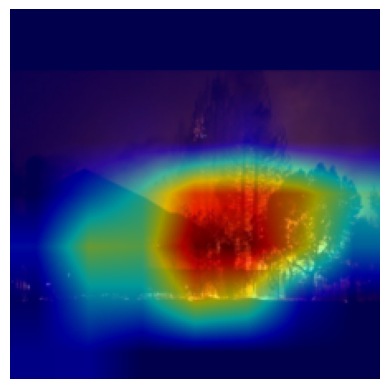

In [87]:
x = (image.to(device),
     {k: v.to(device) for k, v in text_tokens.items()})
img_path = data['path_image'][0]
#print(img_path)
y = torch.tensor([target]).to(device)
#print("y in the prediction function",y)
#input_tensor = data['image'].to(device)
#image = grad_cam(model, x, heatmap_layer,y)
#plt.savefig('./images/input_grad-cam_v1')
model.eval()
#with torch.no_grad():
#    logits = model(x)

logits = model(x)
# indices is a tensor of predictions
org_img = image.to(device)
indices = torch.argmax(logits, dim=1).to(dtype=torch.int32)

print(indices)

image = grad_cam(model, x, heatmap_layer,img_path)

# Remove the axes
plt.axis('off')

plt.imshow(image)

# Remove the axes
plt.axis('off')

plt.savefig('./images/input_grad-cam_v2_new_2',bbox_inches='tight', pad_inches=0)

In [2]:
x=1

In [ ]:
y

In [ ]:
for data in train_loader:

    #print(data['image'])
    #if data['label'] == 4 and data['path_image'][0]=='./datasets/CrisisMMD_v2.0/data_image/california_wildfires/10_10_2017/917815040962695168_1.jpg':
    x = (data['image'].to(device),
         {k: v.to(device) for k, v in data['text_tokens'].items()})
    img_path = data['path_image'][0]
    #print(img_path)
    print(x)
    y = data['label'].to(device)
    #print("y in the prediction function",y)
    #input_tensor = data['image'].to(device)
    #image = grad_cam(model, x, heatmap_layer,y)
    #plt.savefig('./images/input_grad-cam_v1')

    logits = model(x)
    # indices is a tensor of predictions
    org_img = data['image'].to(device)
    indices = torch.argmax(logits, dim=1).to(dtype=torch.int32)

    print(indices)

    image = grad_cam(model, x, heatmap_layer,img_path)
    plt.imshow(image)
    plt.savefig('./images/input_grad-cam_v2')


In [ ]:
y[0]

# humanitarian


In [1]:
import pandas as pd

In [90]:
humanitarian_train_df = pd.read_csv('./datasets/CrisisMMD_v2.0/crisismmd_datasplit_all/wiki_settingA/task_humanitarian_text_img_train.tsv', sep = '\t')

humanitarian_train_df=humanitarian_train_df[humanitarian_train_df.label_text == humanitarian_train_df.label_image]

humanitarian_train_df#.label_image.value_counts()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,final_text
0,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT KAKEnews California wildfires destroy 50 st...
1,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT KAKEnews California wildfires destroy 50 st...
2,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT KAKEnews California wildfires destroy 50 st...
3,california_wildfires,917815040962695168,917815040962695168_2,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT TheAtlantic Photos Californias destructive ...
4,california_wildfires,917828283047260161,917828283047260161_0,Why California's #wildfires are worse in the f...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,other_relevant_information,Positive,Californias wildfires worse fall california_wi...
...,...,...,...,...,...,...,...,...,...,...
2869,hurricane_irma,910250204812632064,910250204812632064_0,For those needing recovery assistance from Hur...,data_image/hurricane_irma/19_9_2017/9102502048...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,Positive,needing recovery assistance Hurricane Irma PBC...
2870,hurricane_harvey,904997956486496258,904997956486496258_0,Fossil fuel didnt cause Hurricane Harvey Its s...,data_image/hurricane_harvey/5_9_2017/904997956...,other_relevant_information,other_relevant_information,other_relevant_information,Positive,Fossil fuel didnt cause Hurricane Harvey savin...
2871,hurricane_harvey,908365073176985600,908365073176985600_0,Help us lift up our Texan friends as they pick...,data_image/hurricane_harvey/14_9_2017/90836507...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,Positive,Help us lift Texan friends pick pieces Harvey ...
2872,hurricane_harvey,904277366851198982,904277366851198982_0,RT @MIGOP: President Trump and @FLOTUS serving...,data_image/hurricane_harvey/3_9_2017/904277366...,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,rescue_volunteering_or_donation_effort,Positive,RT MIGOP President Trump FLOTUS serving meals ...


In [2]:
inf_train_df = pd.read_csv('./datasets/CrisisMMD_v2.0/crisismmd_datasplit_all/settingA/task_informative_text_img_train.tsv', sep = '\t')

inf_train_df=inf_train_df[inf_train_df.label_text == inf_train_df.label_image]

inf_train_df#.label_image.value_counts()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
1,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
2,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
3,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
4,california_wildfires,917815040962695168,917815040962695168_0,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive
...,...,...,...,...,...,...,...,...,...
9594,hurricane_irma,910172979526594561,910172979526594561_0,"On the Cone of Concern graphic, I plotted Irma...",data_image/hurricane_irma/19_9_2017/9101729795...,informative,informative,informative,Positive
9595,california_wildfires,921051431368515584,921051431368515584_0,California Wildfires Climate Change Fire Depen...,data_image/california_wildfires/19_10_2017/921...,informative,informative,informative,Positive
9596,hurricane_harvey,905114243871240192,905114243871240192_0,Siri rescues sick teen from Hurricane Harvey -...,data_image/hurricane_harvey/5_9_2017/905114243...,informative,informative,informative,Positive
9597,california_wildfires,919938318795788288,919938318795788288_0,Wells Fargo ATMs are now accepting donations f...,data_image/california_wildfires/16_10_2017/919...,informative,informative,informative,Positive


In [32]:
task3_train_df = pd.read_csv('./datasets/CrisisMMD_v2.0/crisismmd_datasplit_all/settingA/task_damage_text_img_train.tsv', sep = '\t')

#task3_train_df=task3_train_df[task3_train_df.label_text == task3_train_df.label_image]

task3_train_df#.label_image.value_counts()

,event_name,tweet_id,image_id,tweet_text,image,label
0,hurricane_harvey,905960092822003712,905960092822003712_0,"RT @tveitdal: Where Harvey is hitting hardest,...",data_image/hurricane_harvey/8_9_2017/905960092...,severe_damage
1,california_wildfires,918008272363368448,918008272363368448_0,"#NAPA #California #wildfires HORRIBLE, NO WORD...",data_image/california_wildfires/11_10_2017/918...,severe_damage
2,hurricane_irma,909396901254090752,909396901254090752_0,RT @business: Caribbean tax haven begins to bo...,data_image/hurricane_irma/17_9_2017/9093969012...,severe_damage
3,hurricane_maria,912097936200355841,912097936200355841_0,"@StormReportWX Steve, have you seen this from ...",data_image/hurricane_maria/24_9_2017/912097936...,severe_damage
4,hurricane_maria,922610290281402368,922610290281402368_1,Thanks for following! please share! https://t....,data_image/hurricane_maria/23_10_2017/92261029...,little_or_no_damage
...,...,...,...,...,...,...
2463,hurricane_irma,905636943630884865,905636943630884865_0,RT @LoopJamaica: Barbuda declared uninhabitabl...,data_image/hurricane_irma/7_9_2017/90563694363...,severe_damage
2464,iraq_iran_earthquake,930068973206622213,930068973206622213_1,RT @TruTawar: Earthquake Kurdistan Iran https:...,data_image/iraq_iran_earthquake/13_11_2017/930...,mild_damage
2465,mexico_earthquake,910691589034409984,910691589034409984_0,Mexico Earthquake: 2 Cathedrals Sustain Damage...,data_image/mexico_earthquake/21_9_2017/9106915...,little_or_no_damage
2466,mexico_earthquake,910537563974307842,910537563974307842_0,Dramatic video shows moment of gas explosion a...,data_image/mexico_earthquake/20_9_2017/9105375...,severe_damage


In [34]:
labels_task2_merged = {
    'infrastructure_and_utility_damage': 0,
    'not_humanitarian': 1,
    'other_relevant_information': 2,
    'rescue_volunteering_or_donation_effort': 3,
    'vehicle_damage': 4,
    'affected_individuals': 5,
    'injured_or_dead_people': 5,
    'missing_or_found_people': 5,
}

labels_task1 = {
    'informative': 1,
    'not_informative': 0
}


labels_task3 = {
    'little_or_no_damage': 0,
    'mild_damage': 1,
    'severe_damage' : 2
}


In [92]:
# Create a new column 'value' and map the labels to their corresponding values
humanitarian_train_df['label_value'] = humanitarian_train_df['label'].map(labels_task2_merged)



In [93]:
humanitarian_train_df.head(2)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,final_text,label_value
0,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT KAKEnews California wildfires destroy 50 st...,0
1,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive,RT KAKEnews California wildfires destroy 50 st...,0


In [34]:
# Create a new column 'value' and map the labels to their corresponding values
inf_train_df['label_value'] = inf_train_df['label'].map(labels_task1)

In [35]:
inf_train_df.head(2)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,label_value
0,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,1
1,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,1


In [35]:
# Create a new column 'value' and map the labels to their corresponding values
task3_train_df['label_value'] = task3_train_df['label'].map(labels_task3)

In [36]:
task3_train_df.head(2)

,event_name,tweet_id,image_id,tweet_text,image,label,label_value
0,hurricane_harvey,905960092822003712,905960092822003712_0,"RT @tveitdal: Where Harvey is hitting hardest,...",data_image/hurricane_harvey/8_9_2017/905960092...,severe_damage,2
1,california_wildfires,918008272363368448,918008272363368448_0,"#NAPA #California #wildfires HORRIBLE, NO WORD...",data_image/california_wildfires/11_10_2017/918...,severe_damage,2


In [37]:
base_folder_path = '/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main/datasets/CrisisMMD_v2.0/'

KeyboardInterrupt: 

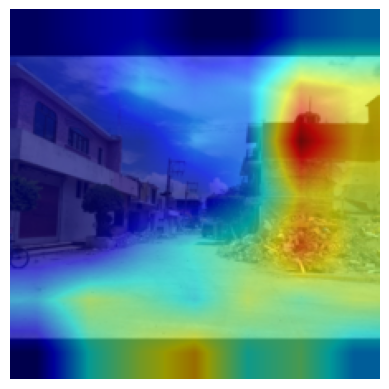

In [42]:
for index,row in task3_train_df.iterrows():
    input_text = row['tweet_text']
    input_image_path = row['image']
    input_image = os.path.join(base_folder_path,input_image_path)
    #print(input_image)
    target =  int(row['label_value'])
    #print(target)
    with Image.open(input_image).convert('RGB') as img:
            image = transforms(img)
    
    image=image.unsqueeze(0)
    
    text_tokens = tokenize(input_text)
    
    x = (image.to(device),
     {k: v.to(device) for k, v in text_tokens.items()})
    
    #img_path = data['path_image'][0]
    #print(img_path)
    
    y = torch.tensor([target]).to(device)
    
    #print("y in the prediction function",y)
    #input_tensor = data['image'].to(device)
    #image = grad_cam(model, x, heatmap_layer,y)
    #plt.savefig('./images/input_grad-cam_v1')
    model.eval()
    #with torch.no_grad():
    #    logits = model(x)

    logits = model(x)
    # indices is a tensor of predictions
    org_img = image.to(device)
    indices = torch.argmax(logits, dim=1).to(dtype=torch.int32)

    #print(indices)

    grad_image = grad_cam(model, x, heatmap_layer,input_image)

    # Remove the axes
    plt.axis('off')

    plt.imshow(grad_image)

    # Remove the axes
    #plt.axis('off')
    
    filename = input_image.split('/')[-1].split('.')[0]
    plt.savefig(f'./gradcam_images/task3/{filename}.jpg',bbox_inches='tight', pad_inches=0)
    
    

In [ ]:

    filename = data['path_image'][0].split('/')[-1].split('.')[0]
    if pred_label == ground_label :
        #print("yes") 
        plt.axis('off')
        plt.savefig(f'./images/correct_prediction/{filename}_{pred_label}_{ground_label}.jpg')    
    else :
        plt.axis('off')
        plt.savefig(f'./images/incorrect_prediction/{filename}_{pred_label}_{ground_label}.jpg') 

In [37]:
ls

args.py                            main.ipynb            preprocess.py
base_dataset.py                    main.py               __pycache__/
calc_metric.ipynb                  mm_models_old.py      README.md
crisismmd_dataset.py               mm_models.py          requirements.txt
datasets/                          optimization.py       setup.sh
ghostnet.ipynb                     output/               train_debug.sh
gradcam_images/                    paths.py              trainer.py
grad_cam_original_img_study.ipynb  prediction.csv        train.sh
gradcam_w_change_v1.ipynb          prediction-task1.csv  view_predictions.ipynb
images/                            prediction-task2.csv  wikinet_tagme/


In [38]:
cd gradcam_images/

/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main_change/gradcam_images


In [39]:
mkdir task3

In [40]:
cd ..

/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main_change


In [ ]:
image = '/home/gupta.37/work/crisisMMD/Multimodal-Categorization-of-Crisis-Events-in-Social-Media-main/datasets/CrisisMMD_v2.0/data_image/california_wildfires/10_10_2017/917793137925459968_2.jpg'
text = 'RT @KAKEnews: California wildfires destroy more than 50 structures: https://t.co/IkSrNpmT83 #KAKEnews https://t.co/8risKwbBqr'
target=4